<a href="https://colab.research.google.com/github/yiiyama/qc-workbook-lecturenotes/blob/branch-2024/2024_04_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHSH不等式の破れを確認する

$\newcommand{\ket}[1]{|#1\rangle}$

## まずこのセルを実行してから授業を始めます

In [1]:
# まずは必要になるpythonモジュールのライブラリファイルをコピーし、すべてインポートしておく
import os
import sys
import shutil
import tarfile
from google.colab import drive
drive.mount('/content/gdrive')
shutil.copy('/content/gdrive/MyDrive/qcintro.tar.gz', '.')
with tarfile.open('qcintro.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/root/.local')

sys.path.append('/root/.local/lib/python3.10/site-packages')

Mounted at /content/gdrive


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

runtime_config_path = '/content/gdrive/MyDrive/qiskit-ibm.json'

circuits = []

angles = [
    (None, -np.pi / 4.),
    (None, -3. * np.pi / 4.),
    (-np.pi / 2., -np.pi / 4.),
    (-np.pi / 2., -3. * np.pi / 4.)
]

for angle0, angle1 in angles:
    circuit = QuantumCircuit(2)
    circuit.h(0)
    circuit.cx(0, 1)

    if angle0 is not None:
        circuit.ry(angle0, 0)
    if angle1 is not None:
        circuit.ry(angle1, 1)

    circuit.measure_all()

    circuits.append(circuit)

service = QiskitRuntimeService(filename=runtime_config_path)
backend = service.least_busy(simulator=False, operational=True)
sampler = Sampler(backend)

shots = 10000
sampler.options.default_shots = shots

circuits = transpile(circuits, backend=backend)
job = sampler.run(circuits)

print(f'Backend: {backend.name}')
print(f'Job ID: {job.job_id()}')

Backend: ibm_kawasaki
Job ID: crfysky69sp0008qfrn0


## 最初の量子回路

In [3]:
circuit = QuantumCircuit(2) # レジスタを介さずビット数を指定して回路を作成することもできます
circuit.h(0) # その場合、ゲートにはregister[0]ではなく直接量子ビットの番号を指定します
circuit.ry(np.pi / 2., 0) #　θ = π/2
circuit.x(0)
# 実際の回路では出力を得るためには必ず最後に測定を行う
circuit.measure_all()

print(f'This circuit has {circuit.num_qubits} qubits and {circuit.size()} operations')

This circuit has 2 qubits and 5 operations


### 回路の数式表現

$$
\begin{align}
X R_y\left(\frac{\pi}{2}\right) H \ket{0} & = X R_y\left(\frac{\pi}{2}\right) \frac{1}{\sqrt{2}}(\ket{0} + \ket{1}) \\
& = \frac{1}{\sqrt{2}} X \left[\left(\cos\left(\frac{\pi}{4}\right)\ket{0} + \sin\left(\frac{\pi}{4}\right)\ket{1}\right) + \left(-\sin\left(\frac{\pi}{4}\right)\ket{0} + \cos\left(\frac{\pi}{4}\right)\ket{1}\right)\right] \\
& = \frac{1}{\sqrt{2}} X \frac{1}{\sqrt{2}} \left[\left(\ket{0} + \ket{1}\right) + \left(-\ket{0} + \ket{1}\right)\right] \\
& = X \ket{1} \\
& = \ket{0}
\end{align}
$$

## 制御ゲートを使った例

In [14]:
theta1 = 2. * np.arctan(np.sqrt(7. / 3.))
theta2 = 2. * np.arctan(np.sqrt(2.))
theta3 = 2. * np.arctan(np.sqrt(4. / 3))

circuit = QuantumCircuit(2)
circuit.ry(theta1, 1)
circuit.ry(theta2, 0)
circuit.cry(theta3 - theta2, 1, 0) # C[Ry]　1が制御で0が標的
circuit.cz(0, 1) # C[Z] 0が制御で1が標的（実はC[Z]ではどちらが制御でも結果は同じ）
circuit.measure_all()

print(f'This circuit has {circuit.num_qubits} qubits and {circuit.size()} operations')

This circuit has 2 qubits and 6 operations


### 回路の数式表現

$$
\begin{align}
R_y(\theta_1)\ket{0} & = \sqrt{\frac{3}{10}} \ket{0} + \sqrt{\frac{7}{10}} \ket{1} \\
R_y(\theta_2)\ket{0} & = \sqrt{\frac{1}{3}} \ket{0} + \sqrt{\frac{2}{3}} \ket{1} \\
R_y(\theta_3 - \theta_2)R_y(\theta_2)\ket{0} & = R_y(\theta_3)\ket{0} = \sqrt{\frac{3}{7}} \ket{0} + \sqrt{\frac{4}{7}} \ket{1}.
\end{align}
$$

したがって、

$$
\begin{align}
& C^1_0[R_y(\theta_3 - \theta_2)]R_{y1}(\theta_1)R_{y0}(\theta_2)\ket{0}_1\ket{0}_0 \\
= & C^1_0[R_y(\theta_3 - \theta_2)]\left(\sqrt{\frac{3}{10}} \ket{0}_1 + \sqrt{\frac{7}{10}} \ket{1}_1\right) R_y(\theta_2)\ket{0}_0\\
= & \sqrt{\frac{3}{10}} \ket{0}_1 R_y(\theta_2)\ket{0}_0 + \sqrt{\frac{7}{10}} \ket{1}_1 R_y(\theta_3)\ket{0}_0 \\
= & \sqrt{\frac{3}{10}} \ket{0}_1 \left(\sqrt{\frac{1}{3}} \ket{0}_0 + \sqrt{\frac{2}{3}} \ket{1}_0\right) + \sqrt{\frac{7}{10}} \ket{1}_1 \left(\sqrt{\frac{3}{7}} \ket{0}_0 + \sqrt{\frac{4}{7}} \ket{1}_0\right) \\
= & \sqrt{\frac{1}{10}} \ket{00} + \sqrt{\frac{2}{10}} \ket{01} + \sqrt{\frac{3}{10}} \ket{10} + \sqrt{\frac{4}{10}} \ket{11}
\end{align}
$$

最初の行で、ビット0と1にかかる$R_y$ゲートをそれぞれ$R_{y0}, R_{y1}$と表しました。

最後に$C[Z]$をかけると、$\ket{11}$だけ符号が反転します。

## 回路図

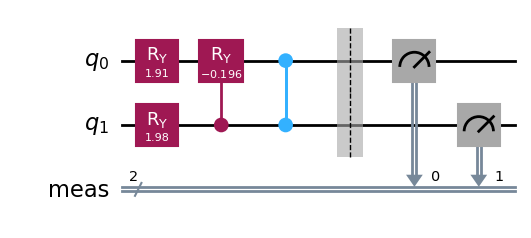

In [15]:
circuit.draw('mpl')

In [16]:
circuit.draw()

┌────────────┐┌──────────────┐    ░ ┌─┐   
   q_0: ┤ Ry(1.9106) ├┤ Ry(-0.19649) ├─■──░─┤M├───
        ├────────────┤└──────┬───────┘ │  ░ └╥┘┌─┐
   q_1: ┤ Ry(1.9823) ├───────■─────────■──░──╫─┤M├
        └────────────┘                    ░  ║ └╥┘
meas: 2/═════════════════════════════════════╩══╩═
                                             0  1

## CHSH不等式を計算する回路を書く

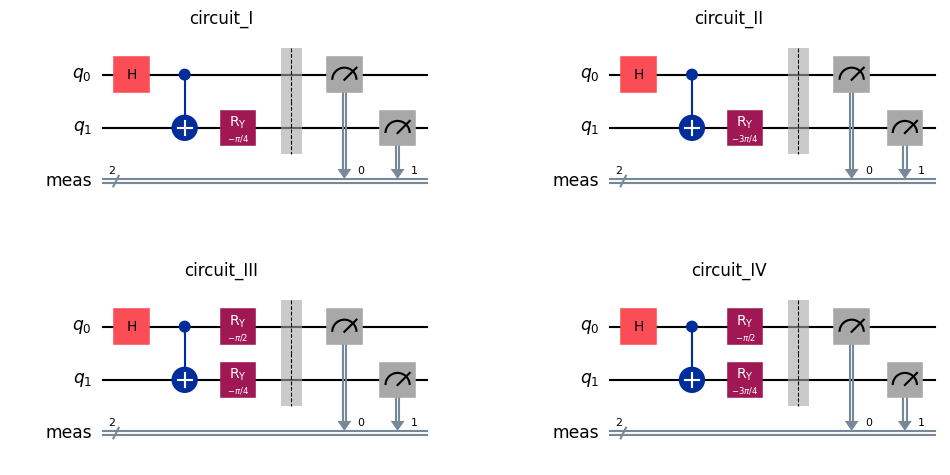

In [17]:
circuits = []

# 回路I - H, CX[0, 1], Ry(-π/4)[1]をかける
circuit = QuantumCircuit(2, name='circuit_I')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-np.pi / 4., 1)
circuit.measure_all()
# 回路リストに追加
circuits.append(circuit)

# 回路II - H, CX[0, 1], Ry(-3π/4)[1]をかける
circuit = QuantumCircuit(2, name='circuit_II')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)
circuit.measure_all()
# 回路リストに追加
circuits.append(circuit)

# 回路III - H, CX[0, 1], Ry(-π/4)[1], Ry(-π/2)[0]をかける
circuit = QuantumCircuit(2, name='circuit_III')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-np.pi / 4., 1)
circuit.ry(-np.pi / 2., 0)
circuit.measure_all()
# 回路リストに追加
circuits.append(circuit)

# 回路IV - H, CX[0, 1], Ry(-3π/4)[1], Ry(-π/2)[0]をかける
circuit = QuantumCircuit(2, name='circuit_IV')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)
circuit.ry(-np.pi / 2., 0)
circuit.measure_all()
# 回路リストに追加
circuits.append(circuit)

# draw()にmatplotlibのaxesオブジェクトを渡すと、そこに描画してくれる
# 一つのノートブックセルで複数プロットしたい時などに便利
fig, axs = plt.subplots(2, 2, figsize=[12., 6.])
for circuit, ax in zip(circuits, axs.reshape(-1)):
    circuit.draw('mpl', ax=ax)
    ax.set_title(circuit.name)

## 回路を実機で実行する

In [18]:
service = QiskitRuntimeService(filename=runtime_config_path)
backend = service.least_busy(simulator=False, operational=True)
sampler = Sampler(backend)

print(f'Jobs will run on {backend.name}')

Jobs will run on ibm_sherbrooke


In [19]:
# バックエンドごとに決められている最大ショット数
shots = 10000
max_shots = backend.configuration().max_shots
sampler.options.default_shots = shots
print(f'Running four circuits, {shots} shots each where {max_shots} shots are allowed')

# transpileの説明は次回の実習にて
circuits = transpile(circuits, backend=backend)
# バックエンドで回路をshots回実行させ、測定結果を返させる
# すでに最初のセルで同じジョブを投げているので、次の行はコメントアウトしている
#job = sampler.run(circuits)

Running four circuits, 10000 shots each where 100000 shots are allowed


### （カーネルを再起動するなどで）ジョブオブジェクトが無効になったら

In [20]:
#job = service.job('__job_id__')

<RuntimeJob('crfysky69sp0008qfrn0', 'sampler')>

### IBM Quantumのよく使うページ

<a href="https://quantum.ibm.com/services/resources" target="_blank">バックエンド一覧</a>

- バックエンドを一つクリックすると詳細が表示される
- 現在の全ジョブ数が Total pending jobs として表示される
- Instance access limits という欄でバックエンドのジョブあたりの最大ショット数と最大回路数を確認できる

<a href="https://quantum.ibm.com/jobs" target="_blank">ジョブ一覧</a>

## 量子測定結果の解析

### ジョブの結果をダウンロード

In [24]:
result = job.result()

# 4つの回路のヒストグラムデータを入れるリスト
counts_list = []

# 回路ごとの結果をresultから抽出する
for idx in range(4):
    # get_counts(i)で回路iのヒストグラムデータが得られる
    counts = result[idx].data.meas.get_counts()
    # データをリストに足す
    counts_list.append(counts)

print(counts_list)

[{'00': 4013, '11': 4285, '10': 836, '01': 866}, {'00': 843, '10': 4101, '01': 4252, '11': 804}, {'00': 4384, '11': 4157, '10': 781, '01': 678}, {'10': 772, '00': 4339, '11': 4197, '01': 692}]


### ヒストグラムの表示

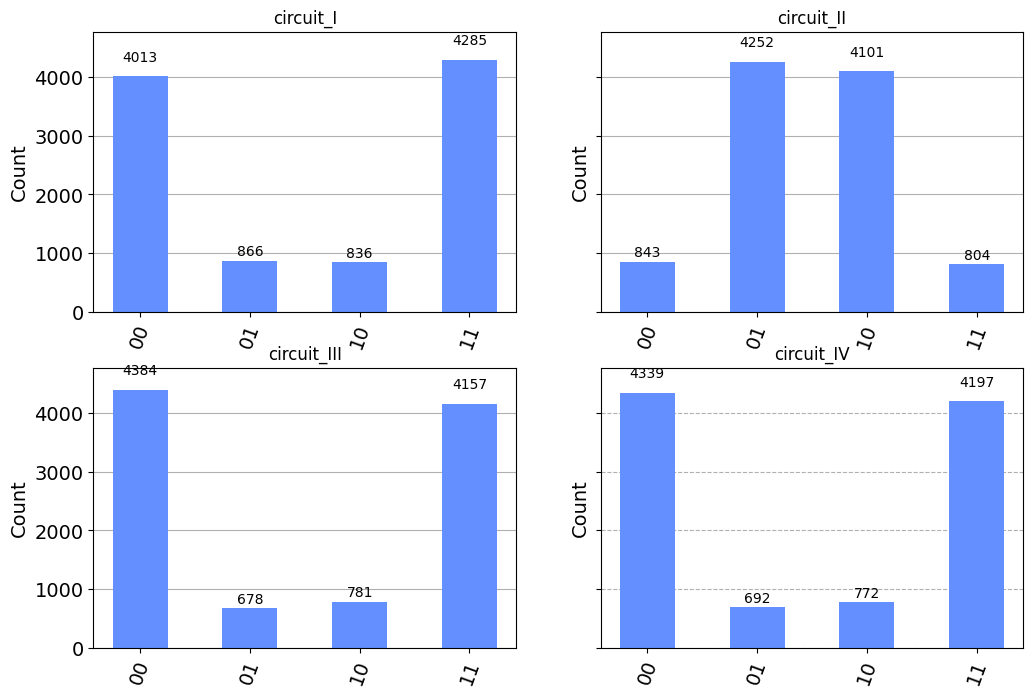

In [25]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=[12., 8.])
for counts, circuit, ax in zip(counts_list, circuits, axs.reshape(-1)):
    plot_histogram(counts, ax=ax)
    ax.set_title(circuit.name)
    ax.yaxis.grid(True)

### $S$の値

In [27]:
# C^I, C^II, C^III, C^IVを一つのアレイにする
#（今の場合ただのリストにしてもいいが、純粋な数字の羅列にはnumpy arrayを使うといいことが多い）
c_arr = np.zeros(4, dtype=float)

# enumerate(L)でリストのインデックスと対応する要素に関するループを回せる
for ic, counts in enumerate(counts_list):
    # counts['00'] でなく counts.get('00', 0) - 上のテキストを参照
    c_arr[ic] = counts.get('00', 0) + counts.get('11', 0) - counts.get('01', 0) - counts.get('10', 0)

# 4つの要素を同時に和で規格化（リストではこういうことはできない）
c_arr /= shots

s_val = c_arr[0] - c_arr[1] + c_arr[2] + c_arr[3]

print('C:', c_arr)
print('S =', s_val)
if s_val > 2.:
    print('Yes, we are using a quantum computer!')
else:
    print('Armonk, we have a problem.')

C: [ 0.6596 -0.6706  0.7082  0.7072]
S = 2.7456000000000005
Yes, we are using a quantum computer!
